<a href="https://colab.research.google.com/github/JahedNaghipoor/Classification-of-genes/blob/main/DNA_Sequencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DNA Sequencing 
predicting a gene's function based on the DNA sequence of the coding sequence alone

In [57]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

import os

In [59]:
directory = "/content/gdrive/MyDrive/Machine Learning and Deep Learning/Gene Classification/"

In [60]:
human_data = pd.read_table(os.path.join(directory, 'human_data.txt'))
human_data.head(10)

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3
5,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
6,ATGAAGATTGCACACAGAGGTCCAGATGCATTCCGTTTTGAGAATG...,3
7,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3
8,ATGAAGATTGCACACAGAGGTCCAGATGCATTCCGTTTTGAGAATG...,3
9,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3


In [61]:
human_data['length of sequence'] = human_data.sequence.apply(len)

In [62]:
human_data.head()

,sequence,class,length of sequence
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,207
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,681
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1686
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1206
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,1437


In [63]:
human_data.isnull().sum()

sequence              0
class                 0
length of sequence    0
dtype: int64

In [64]:
human_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sequence            4380 non-null   object
 1   class               4380 non-null   int64 
 2   length of sequence  4380 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 102.8+ KB


In [65]:
human_data.describe()

,class,length of sequence
count,4380.000000,4380.000000
mean,3.504566,1263.598630
std,2.132134,1280.754087
min,0.000000,5.000000
25%,2.000000,405.000000
50%,4.000000,865.000000
75%,6.000000,1662.000000
max,6.000000,18921.000000


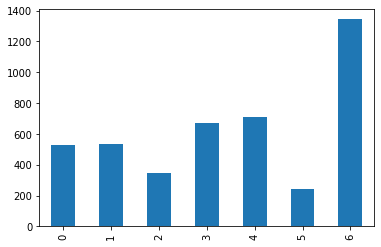

In [66]:
human_data['class'].value_counts().sort_index().plot(kind='bar')

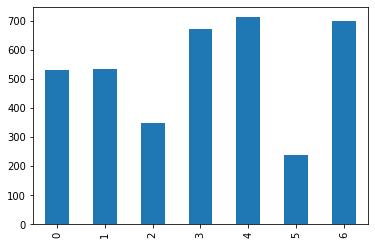

In [67]:
from sklearn.utils import resample
# Separate class 6 and other classes
df_without_class6 = human_data[human_data['class']!=6]
df_with_class6 = human_data[human_data['class']==6]
 
# Upsample minority class
df_with_class6 = resample(df_with_class6, 
                                 replace=True,     
                                 n_samples=700,    
                                 random_state=123)
human_data = pd.concat([df_with_class6, df_without_class6])
human_data['class'].value_counts().sort_index().plot(kind='bar')

### Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string. We will basically apply the k-mers to the complete sequences.

In [68]:
'''https://bioinfologics.github.io/post/2018/09/17/k-mer-counting-part-i-introduction/'''
def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

## Now we can convert our training data sequences into short overlapping  k-mers of legth 6.  Lets do that for each species of data we have using our getKmers function.

In [69]:
human_data['words'] = human_data.apply(lambda x: getKmers(sequence=x['sequence'], size=5), axis=1)
human_data = human_data.drop('sequence', axis=1)

### Now, our coding sequence data is changed to lowercase, split up into all possible k-mer words of length 6 and ready for the next step.  Let's take a look.

In [70]:
human_data.head()

,class,length of sequence,words
3609,6,1809,"[atgtc, tgtcg, gtcga, tcgaa, cgaat, gaatg, aat..."
3260,6,1263,"[ncttt, ctttt, ttttg, tttgc, ttgca, tgcag, gca..."
228,6,1476,"[atggt, tggtc, ggtct, gtctg, tctgt, ctgta, tgt..."
3659,6,1314,"[atggc, tggcc, ggcct, gcctt, ccttg, cttgg, ttg..."
4054,6,333,"[gccgt, ccgtg, cgtgc, gtgca, tgcag, gcagc, cag..."


In [71]:
human_data['number of k-mer words'] = human_data.words.apply(len)

In [72]:
human_data.head(10)

,class,length of sequence,words,number of k-mer words
3609,6,1809,"[atgtc, tgtcg, gtcga, tcgaa, cgaat, gaatg, aat...",1805
3260,6,1263,"[ncttt, ctttt, ttttg, tttgc, ttgca, tgcag, gca...",1259
228,6,1476,"[atggt, tggtc, ggtct, gtctg, tctgt, ctgta, tgt...",1472
3659,6,1314,"[atggc, tggcc, ggcct, gcctt, ccttg, cttgg, ttg...",1310
4054,6,333,"[gccgt, ccgtg, cgtgc, gtgca, tgcag, gcagc, cag...",329
218,6,204,"[atgcg, tgcgt, gcgtg, cgtgc, gtgcc, tgccg, gcc...",200
244,6,1056,"[atgac, tgacc, gaccg, accga, ccgaa, cgaaa, gaa...",1052
2097,6,810,"[atgta, tgtac, gtaca, tacaa, acaaa, caaag, aaa...",806
106,6,505,"[atgaa, tgaat, gaatg, aatga, atgat, tgatt, gat...",501
138,6,1326,"[atgaa, tgaag, gaagg, aaggc, aggcg, ggcgg, gcg...",1322


### Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use.  We can also make a y variable to hold the class labels.  Let's do that now.

In [73]:
human_texts = list(human_data['words'])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_data = human_data.iloc[:, 0].values                         

In [74]:
print(human_texts[2])

atggt tggtc ggtct gtctg tctgt ctgta tgtac gtaca tacaa acaat caata aatat atatg tatgt atgtc tgtca gtcaa tcaag caaga aagaa agaag gaaga aagag agagt gagta agtat gtatt tattc attca ttcag tcaga cagaa agaag gaagc aagct agctc gctcc ctccc tccca cccaa ccaat caatg aatga atgaa tgaaa gaaat aaatg aatgg atggt tggtt ggtta gttat ttata tatat atatg tatgt atgtg tgtga gtgac tgaca gacaa acaag caagt aagtg agtgt gtgtg tgtgg gtggc tggcc ggcca gccaa ccaag caagg aagga aggat ggata gatat atatc tatca atcat tcatc catca atcag tcagt cagtt agttg gttgt ttgtg tgtgt gtgtc tgtca gtcac tcaca cacac acaca cacac acacc cacct acctc cctca ctcat tcata catat atatt tattg attga ttgat tgatt gattc attcc ttcca tccag ccagt cagtg agtgt gtgtg tgtga gtgat tgatt gattg attga ttgat tgatt gattc attca ttcag tcaga cagat agatg gatga atgaa tgaaa gaaaa aaaaa aaaat aaatg aatgg atggc tggct ggctc gctct ctctg tctgt ctgtc tgtcg gtcgg tcggc cggca ggcag gcagt cagtg agtgt gtgtg tgtgt gtgtt tgttt gtttt ttttt ttttg tttgc ttgca tgcaa gcaac caaca aacaa acaac caac

In [75]:
y_data

array([6, 6, 6, ..., 0, 0, 0])

## Now we will apply the BAG of WORDS using CountVectorizer using NLP

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)

In [77]:
print(X.shape)

(3737, 65264)


In [78]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_data, 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [79]:
print(X_train.shape)
print(X_test.shape)

(2989, 65264)
(748, 65264)


In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [82]:
y_pred = classifier.predict(X_test)

In [83]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

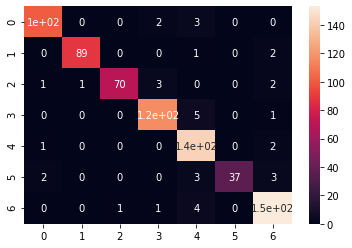

In [84]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)

In [85]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       106
           1       0.99      0.97      0.98        92
           2       0.99      0.91      0.95        77
           3       0.95      0.95      0.95       123
           4       0.90      0.98      0.94       146
           5       1.00      0.82      0.90        45
           6       0.94      0.96      0.95       159

    accuracy                           0.95       748
   macro avg       0.96      0.93      0.95       748
weighted avg       0.95      0.95      0.95       748



In [86]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \n precision = %.3f \n recall = %.3f \n f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.949 
 precision = 0.951 
 recall = 0.949 
 f1 = 0.949
